#Feature Engineering

In [1]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##Load celtra data (10% random subsample of the large data)

In [25]:
data = graphlab.SFrame.read_csv('E:\celtraMiningFrik\ccdm_mine.csv',column_type_hints=str);

Read 69661 lines. Lines per second: 52334.3

Finished parsing file E:\celtraMiningFrik\ccdm_mine.csv

Parsing completed. Parsed 245377 lines in 3.70821 secs.

##### Convert numeric types from string to int/float

In [30]:
data['ADLOADINGTIME']=data['ADLOADINGTIME'].astype(float)
data['GEOIP_LAT'] = data['GEOIP_LAT'].apply(lambda x: 0 if x=='null' else x)
data['GEOIP_LAT']=data['GEOIP_LAT'].astype(float)
data['GEOIP_LNG'] = data['GEOIP_LNG'].apply(lambda x: 0 if x=='null' else x)
data['GEOIP_LNG']=data['GEOIP_LNG'].astype(float)
data['TIMESTAMP']=data['TIMESTAMP'].astype(int)
data['HOSTWINDOWHEIGHT'] = data['HOSTWINDOWHEIGHT'].apply(lambda x: 0 if x=='null' else x)
data['HOSTWINDOWHEIGHT']=data['HOSTWINDOWHEIGHT'].astype(int)
data['HOSTWINDOWWIDTH'] = data['HOSTWINDOWWIDTH'].apply(lambda x: 0 if x=='null' else x)
data['HOSTWINDOWWIDTH']=data['HOSTWINDOWWIDTH'].astype(int)
data['TOPMOSTREACHABLEWINDOWHEIGHT'] = data['TOPMOSTREACHABLEWINDOWHEIGHT'].apply(lambda x: 0 if x=='null' else x)
data['TOPMOSTREACHABLEWINDOWHEIGHT']=data['TOPMOSTREACHABLEWINDOWHEIGHT'].astype(int)
data['TOPMOSTREACHABLEWINDOWWIDTH'] = data['TOPMOSTREACHABLEWINDOWWIDTH'].apply(lambda x: 0 if x=='null' else x)
data['TOPMOSTREACHABLEWINDOWWIDTH']=data['TOPMOSTREACHABLEWINDOWWIDTH'].astype(int)

#####remove EXTERNALCREATIVEID as it is always null

In [31]:
data.remove_column('EXTERNALCREATIVEID');

#####remove NETWORKTYPE as it is mainly null

In [32]:
data.remove_column('NETWORKTYPE');

remove top 5% of ADLOADINGTIME outliers

In [33]:
# 3.7835
perct = 95
print(np.percentile(data['ADLOADINGTIME'],perct))
data = data[data['ADLOADINGTIME']<np.percentile(data['ADLOADINGTIME'],perct)]
print(graphlab.evaluation.rmse(data['ADLOADINGTIME'], graphlab.SArray.from_const(data['ADLOADINGTIME'].mean(),len(data['ADLOADINGTIME']))))

18.7192
3.69722294021


#####show data

In [5]:
data.show()

Canvas is accessible via web browser at the URL: http://localhost:31720/index.html
Opening Canvas in default web browser.


##Feature engineering

combine TOPMOSTREACHABLEWINDOWHEIGHT and TOPMOSTREACHABLEWINDOWWIDTH by multiplication and computation of the ratio

remove data with very large or negative data

In [48]:
data['TOPMOSTREACHABLEWINDOWAREA'] = data['TOPMOSTREACHABLEWINDOWWIDTH']*data['TOPMOSTREACHABLEWINDOWHEIGHT'];
data = data[data['TOPMOSTREACHABLEWINDOWAREA']>=0]
data = data[data['TOPMOSTREACHABLEWINDOWAREA']<1e7]

In [8]:
tmp = data[data['TOPMOSTREACHABLEWINDOWAREA']>1e7]
print(tmp.num_rows())

0


remove all other scree size data except the area

In [49]:
data.remove_column('TOPMOSTREACHABLEWINDOWWIDTH');
data.remove_column('TOPMOSTREACHABLEWINDOWHEIGHT');
data.remove_column('HOSTWINDOWWIDTH');
data.remove_column('HOSTWINDOWHEIGHT');

remove device orientation as it should not affect loading time

In [34]:
data.remove_column('DEVICEORIENTATION');

UA_MOBILEDEVICE can be assesed from PLATFORM -> remove

In [35]:
data.remove_column('UA_MOBILEDEVICE');

In [46]:
data = data[data['TIMESTAMP']>1458500000]
data = data[data['TIMESTAMP']<1461000000]

In [13]:
tmp = data[data['TIMESTAMP']<=1458500000]
print(tmp.num_rows())

0


GEOIP: to start combine COUNTRY with REGION for USA
In my expectation the data is to scarce to have enough entries for exact geolocation and time assignment
-> remove DMACODE, METROCODE, TIMEZONE, CITY, AREACODE

In [36]:
data.remove_column('GEOIP_TIMEZONE');
data.remove_column('GEOIP_METROCODE');
data.remove_column('GEOIP_AREACODE');
data.remove_column('GEOIP_CITY');
data.remove_column('GEOIP_DMACODE');

In [37]:
data['GEOIP_COUNTRY'] = data['GEOIP_COUNTRY'] + '_' + data['GEOIP_REGION'] 
data['GEOIP_COUNTRY'] = data['GEOIP_COUNTRY'].apply(lambda x: x if 'United States' in x.split('_')[0] else x.split('_')[0])
data.remove_column('GEOIP_REGION');

In [101]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
#LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_COUNTRY'],validation_set=test_data, max_iterations=100,verbose=False)
#model = LR_model
#rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
#print("{}: {:.4f}".format('COMBINEDID and GEOIP_COUNTRY',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LAT'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LAT',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG', 'GEOIP_LAT'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG and GEOIP_LAT',rms))
#LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG', 'GEOIP_LAT','GEOIP_COUNTRY'],validation_set=test_data, max_iterations=100,verbose=False)
#model = LR_model
#rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
#print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG and GEOIP_LAT and GEOIP_COUNTRY',rms))

COMBINEDID: 3.4685
COMBINEDID and GEOIP_LAT: 3.4681
COMBINEDID and GEOIP_LNG: 3.4684
COMBINEDID and GEOIP_LNG and GEOIP_LAT: 3.4680


In [102]:
data.remove_columns(['GEOIP_LNG','GEOIP_LAT']);
data.remove_columns(['GEOIP_COUNTRY']);

KeyError: 'Cannot find column GEOIP_COUNTRY'

 **CONCLUSIONS**

GEOIP_DATA just barely results in a reduction of RMSE -> not needed

In [38]:
data['ERRORSJSON'] = data['ERRORSJSON'].apply(lambda x: x.replace('"',''))

crate new feature by extracting sizes of images from FILESJSON

In [39]:
def extractImageSize(sIn):
    sIn = sIn.replace('[','')
    sIn = sIn.replace('}','')
    sIn = sIn.replace(']','')
    sIn = sIn.replace('{"type":"image","size":','')
    numberList = [int(s) for s in sIn.split(',') if s.isdigit()]
    if len(numberList) == 0:
        numberList = 0
    return np.sum(numberList)

data['FILESJSON_SIZE'] = data['FILESJSON'].apply(extractImageSize)

remove outliers from FILESJSON_SIZE

In [42]:
#tmp = data[data['FILESJSON_SIZE']>np.percentile(data['FILESJSON_SIZE'],99)]
#print(np.percentile(data['FILESJSON_SIZE'],99))
#print(tmp.num_rows())
data = data[data['FILESJSON_SIZE']<np.percentile(data['FILESJSON_SIZE'],99)]

The new feature is not very helpful

In [43]:
data.remove_column('FILESJSON_SIZE');

**CONCLUSIONS**

FILESJSON_SIZE is useful to remove some outliers but not as a features -> remove after removal of outliers

#####Create new fetures by combining IDS

In [44]:
data['COMBINEDID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']
data['COMBINEDIDWITHPLACEMENTID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']+'_'+data['PLACEMENTID']
data['COMBINEDEXTERNALID'] = data['EXTERNALPLACEMENTID']+'_'+data['EXTERNALSITEID']+'_'+data['EXTERNALSUPPLIERID']
data['COMBINEDEXTERNALID'] = data['COMBINEDEXTERNALID'].apply(lambda x : 'null' if x == 'null_null' or x== 'null_null_null' else x)

test with simple linear regression

In [50]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['CREATIVEID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('CREATIVEID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['CREATIVEID', 'PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('CREATIVEID and PLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLACEMENTID',rms))

COMBINEDID: 3.4685
COMBINEDID and PLACEMENTID: 3.4629
COMBINEDIDWITHPLACEMENTID: 3.4630
CREATIVEID: 3.4818
CREATIVEID and PLACEMENTID: 3.4705
PLACEMENTID: 3.4748


**CONCLUSIONS**

use COMBINEDID and PLACEMENTID as separate features

In [237]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['EXTERNALPLACEMENTID', 'EXTERNALSITEID', 'EXTERNALSUPPLIERID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('EXTERNALPLACEMENTID and EXTERNALSITEID and EXTERNALSUPPLIERID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDEXTERNALID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID', 'COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID and COMBINEDEXTERNALID',rms))

COMBINEDID: 3.4685
EXTERNALPLACEMENTID and EXTERNALSITEID and EXTERNALSUPPLIERID: 3.5237
COMBINEDIDWITHPLACEMENTID: 3.4630
COMBINEDEXTERNALID: 3.5291
COMBINEDIDWITHPLACEMENTID and COMBINEDEXTERNALID2: 3.4659
COMBINEDEXTERNALID2: 3.5291


**CONCLUSIONS**

do not use any of the following external features: EXTERNALPLACEMENTID, EXTERNALSITEID, EXTERNALSUPPLIERID

######Remove features based on above two conlclusions

In [63]:
data.remove_column('SDK');
data.remove_column('ACCOUNTID');
data.remove_column('CAMPAIGNID');
data.remove_column('CREATIVEID');
data.remove_column('EXTERNALADSERVER');
data.remove_column('COMBINEDIDWITHPLACEMENTID');

In [61]:
data['COMBINEDID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']

In [55]:
data.remove_column('EXTERNALPLACEMENTID');
data.remove_column('EXTERNALSITEID');
data.remove_column('EXTERNALSUPPLIERID');

######Test the need for COMBINEDEXTERNALID

In [85]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDEXTERNALID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and COMBINEDEXTERNALID',rms))

COMBINEDID: 3.4685
COMBINEDEXTERNALID: 3.5291
COMBINEDID and COMBINEDEXTERNALID: 3.4701


**CONCLUSIONS**

COMBINEDEXTERNALID doesn't help with the linear regression, however, it is essential for random forest -> do not remove it!

In [57]:
#data.remove_column('COMBINEDEXTERNALID');

######Test the need for TOPMOSTREACHABLEWINDOWAREA

In [86]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['TOPMOSTREACHABLEWINDOWAREA'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('TOPMOSTREACHABLEWINDOWAREA',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'TOPMOSTREACHABLEWINDOWAREA'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and TOPMOSTREACHABLEWINDOWAREA',rms))

COMBINEDID: 3.4685
TOPMOSTREACHABLEWINDOWAREA: 3.6797
COMBINEDID and TOPMOSTREACHABLEWINDOWAREA: 3.4645


**CONCLUSIONS**

TOPMOSTREACHABLEWINDOWAREA can help sometimes, especially for RF

In [52]:
#data.remove_column('TOPMOSTREACHABLEWINDOWAREA');

######Combine PLATFORM and PLATFORMVERSION

In [111]:
data['PLATFORMCOMBINED'] = data['PLATFORM']+'_'+data['PLATFORMVERSION']

In [112]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORM'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORM',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORMVERSION',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORMCOMBINED',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORM', 'PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORM and PLATFORMVERSION',rms))

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLATFORM'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORM',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMVERSION',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLATFORM', 'PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORM and PLATFORMVERSION',rms))

PLATFORM: 3.6262
PLATFORMVERSION: 3.5990
PLATFORMCOMBINED: 3.5979
PLATFORM and PLATFORMVERSION: 3.5982
COMBINEDID and PLATFORM: 3.3705
COMBINEDID and PLATFORMVERSION: 3.3455
COMBINEDID and PLATFORMCOMBINED: 3.3448
COMBINEDID and PLATFORM and PLATFORMVERSION: 3.3451


**CONCLUSIONS**

PLATFORMCOMBINED is better than separately use PLATFORM and PLATFORMVERSION

In [134]:
data.remove_columns(['PLATFORM','PLATFORMVERSION']);

KeyError: 'Cannot find column PLATFORM'

UA_PLATFORM and PLATFORM, and UA_PLATFORMVERSION and PLATFORMVERSION are practically the same

In [135]:
data.remove_columns(['UA_PLATFORM','UA_PLATFORMVERSION']);

In [120]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))

train_data = train_data[train_data['PLATFORMCOMBINED'] != 'null_null']
#test_data = test_data[test_data['PLATFORMCOMBINED'] != 'null_null']

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))

COMBINEDID: 3.4685
COMBINEDID and PLATFORMCOMBINED: 3.3448
COMBINEDID: 3.4685
COMBINEDID and PLATFORMCOMBINED: 3.3449


**CONCLUSIONS**

No need to remove 'null_null' from PLATFORMCOMBINED

#####Device type from UA

Try combining this features

In [126]:
data['UA_VENDORMODEL'] = data['UA_VENDOR']+'_'+data['UA_MODEL']
data['UA_OSCOMB'] = data['UA_OS']+'_'+data['UA_OSVERSION']
data['UA_BROWSERCOMB'] = data['UA_BROWSER']+'_'+data['UA_BROWSERVERSION']

In [124]:
train_data,test_data = data.random_split(.5,seed=1)

def eval_LR_features(feat, name):
    LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=feat,validation_set=test_data, max_iterations=100,verbose=False)
    model = LR_model
    rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
    print("{}: {:.4f}".format(name,rms))

eval_LR_features(['COMBINEDID', 'UA_VENDOR'], 'COMBINEDID and UA_VENDOR')
eval_LR_features(['COMBINEDID', 'UA_MODEL'], 'COMBINEDID and UA_MODEL')
eval_LR_features(['COMBINEDID', 'UA_OS'], 'COMBINEDID and UA_OS')
eval_LR_features(['COMBINEDID', 'UA_OSVERSION'], 'COMBINEDID and UA_OSVERSION')
eval_LR_features(['COMBINEDID', 'UA_BROWSER'], 'COMBINEDID and UA_BROWSER')
eval_LR_features(['COMBINEDID', 'UA_BROWSERVERSION'], 'COMBINEDID and UA_BROWSERVERSION')

COMBINEDID and UA_VENDOR: 3.3694
COMBINEDID and UA_MODEL: 3.3565
COMBINEDID and UA_OS: 3.3693
COMBINEDID and UA_OSVERSION: 3.3419
COMBINEDID and UA_BROWSER: 3.3737
COMBINEDID and UA_BROWSERVERSION: 3.3385


In [125]:
eval_LR_features(['COMBINEDID', 'UA_VENDOR', 'UA_MODEL'], 'COMBINEDID and UA_VENDOR and UA_MODEL')
eval_LR_features(['COMBINEDID', 'UA_OS', 'UA_OSVERSION'], 'COMBINEDID and UA_OS and UA_OSVERSION')
eval_LR_features(['COMBINEDID', 'UA_BROWSERVERSION', 'UA_BROWSER'], 'COMBINEDID and UA_BROWSERVERSION and UA_BROWSER')

COMBINEDID and UA_VENDOR and UA_MODEL: 3.3554
COMBINEDID and UA_OS and UA_OSVERSION: 3.3415
COMBINEDID and UA_BROWSERVERSION and UA_BROWSER: 3.3359


In [128]:
train_data,test_data = data.random_split(.5,seed=1)

eval_LR_features(['COMBINEDID', 'UA_VENDORMODEL'], 'COMBINEDID and UA_VENDORMODEL')
eval_LR_features(['COMBINEDID', 'UA_OSCOMB'], 'COMBINEDID and UA_OSCOMB')
eval_LR_features(['COMBINEDID', 'UA_BROWSERCOMB'], 'COMBINEDID and UA_BROWSERCOMB')

COMBINEDID and UA_VENDORMODEL: 3.3567
COMBINEDID and UA_OSCOMB: 3.3412
COMBINEDID and UA_BROWSERCOMB: 3.3361


**CONCLUSIONS**

Do not combine UA_BROWSERVERSION and UA_BROWSER

Do not combine UA_VENDOR and UA_MODEL

Combine UA_OS and UA_OSVERSION

In [131]:
data.remove_columns(['UA_BROWSERCOMB', 'UA_VENDORMODEL']);

ADLOADINGTIME,PLACEMENTID,TIMESTAMP,INTENDEDDEVICETYPE,ACTUALDEVICETYPE,CDNNAME
7.121,f6297752e6cd8cd455c55d95c085035d ...,1459512400,Phone,Phone,c
1.616,7b76845786cdb6773e1d0024e9213391 ...,1459513778,Phone,Phone,a
0.947,36793d8fe98b79d0e6bd1ecee0865e4a ...,1459513057,Phone,Phone,a
6.978,04a34aa00b34c0a400427aad3bdaa38a ...,1459513155,Phone,Phone,c
2.713,7e44ca19e19fd7995312204a8985ec45 ...,1459514610,Phone,Phone,c
1.695,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516741,Phone,Phone,a
4.639,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516915,Phone,Phone,c
2.059,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516785,Phone,Phone,b
0.796,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459517035,Phone,Phone,a
2.244,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459517065,Phone,Phone,a


In [132]:
data.remove_columns(['UA_OS', 'UA_OSVERSION']);

###### New feature: waht if INTENDEDDEVICETYPE and ACTUALDEVICETYPE differs

In [99]:
data['INTENDENTISACTUALDEVICETYPE'] = data['INTENDEDDEVICETYPE']==data['ACTUALDEVICETYPE']

In [101]:
train_data,test_data = data.random_split(.5,seed=1)

def eval_LR_features(feat, name):
    LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=feat,validation_set=test_data, max_iterations=100,verbose=False)
    model = LR_model
    rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
    print("{}: {:.4f}".format(name,rms))

eval_LR_features(['COMBINEDID'], 'COMBINEDID')
eval_LR_features(['COMBINEDID', 'INTENDEDDEVICETYPE'], 'COMBINEDID and INTENDEDDEVICETYPE')
eval_LR_features(['COMBINEDID', 'ACTUALDEVICETYPE'], 'COMBINEDID and ACTUALDEVICETYPE')
eval_LR_features(['COMBINEDID', 'INTENDEDDEVICETYPE', 'ACTUALDEVICETYPE'], 'COMBINEDID and INTENDEDDEVICETYPE and ACTUALDEVICETYPE')
eval_LR_features(['COMBINEDID', 'INTENDENTISACTUALDEVICETYPE'], 'COMBINEDID and INTENDENTISACTUALDEVICETYPE')
eval_LR_features(['COMBINEDID', 'INTENDENTISACTUALDEVICETYPE', 'ACTUALDEVICETYPE'], 'COMBINEDID and INTENDENTISACTUALDEVICETYPE and ACTUALDEVICETYPE')

COMBINEDID: 3.4749
COMBINEDID and INTENDEDDEVICETYPE: 3.4749
COMBINEDID and ACTUALDEVICETYPE: 3.4720
COMBINEDID and INTENDEDDEVICETYPE and ACTUALDEVICETYPE: 3.4720
COMBINEDID and INTENDENTISACTUALDEVICETYPE: 3.4733
COMBINEDID and INTENDENTISACTUALDEVICETYPE and ACTUALDEVICETYPE: 3.4718


**CONCLUSIONS**

INTENDEDDEVICETYPE not really needed, retain only ACTUALDEVICETYPE

INTENDENTISACTUALDEVICETYPE can help just a little bit with RF however not with LR -> retain it, why not

Remaining features:

In [100]:
data[0]

{'ACTUALDEVICETYPE': 'Phone',
 'ADLOADINGTIME': 7.121,
 'COMBINEDEXTERNALID': 'null',
 'COMBINEDID': '6650fadcc0264109f8bd976558377652_a0776e9e61f79615d93907ec5710c9fa_ab0a0251add6aba71e800537c6a729c8_83361d7aa1757e5f8e9ed97b71a8c49b_b46e86833f3f102dfeca4b7a13d6db21',
 'CREATIVETYPE': 'Interstitial',
 'ERRORSJSON': '[]',
 'FILESJSON': '[]',
 'FILESJSON_SIZE': 0L,
 'INTENDEDDEVICETYPE': 'Phone',
 'INTENDENTISACTUALDEVICETYPE': 1L,
 'PLACEMENTID': 'f6297752e6cd8cd455c55d95c085035d',
 'PLATFORMCOMBINED': 'Android_4.3',
 'TIMESTAMP': 1459512400L,
 'TOPMOSTREACHABLEWINDOWAREA': 221400L,
 'UA_BROWSER': 'Android Browser',
 'UA_BROWSERRENDERINGENGINE': 'WebKit',
 'UA_BROWSERVERSION': '4.0',
 'UA_DEVICETYPE': 'Phone',
 'UA_HARDWARETYPE': 'Mobile Phone',
 'UA_MODEL': 'SM-G7102',
 'UA_OSCOMB': 'Android_4.3',
 'UA_VENDOR': 'Samsung'}

###Effect of progressively adding more features

In [121]:
train_data,test_data = data.random_split(.5,seed=1)

for col in data.column_names():
    if col != 'ADLOADINGTIME' and  col != 'COMBINEDID':# and col != 'UA_BROWSERVERSION':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

PLACEMENTID: 3.4629
TIMESTAMP: 3.4684
INTENDEDDEVICETYPE: 3.4685
ACTUALDEVICETYPE: 3.4655
CDNNAME: 3.4687
CREATIVETYPE: 3.4685
UA_HARDWARETYPE: 3.4648
UA_DEVICETYPE: 3.4655
UA_PLATFORM: 3.3706
UA_PLATFORMVERSION: 3.3457
UA_VENDOR: 3.3694
UA_MODEL: 3.3565
UA_OS: 3.3693
UA_OSVERSION: 3.3419
UA_BROWSER: 3.3737
UA_BROWSERVERSION: 3.3385
UA_BROWSERRENDERINGENGINE: 3.4672
FILESJSON: 3.4686
ERRORSJSON: 3.4676
COMBINEDEXTERNALID: 3.4701
TOPMOSTREACHABLEWINDOWAREA: 3.4645
PLATFORMCOMBINED: 3.3448


In [19]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'],validation_set=test_data, max_iterations=50,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('',rms))

for col in data.column_names():
    #if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_PLATFORMCOMBINED':
    if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_OSCOMB'and col != 'UA_VENDOR' and col != 'PLATFORMCOMBINED' and col != 'COMBINEDEXTERNALID' and col != 'FILESJSON' and col!='ACTUALDEVICETYPE' and col!= 'ERRORSJSON' and col != 'UA_BROWSER' and col != 'TIMESTAMP' and col != 'CREATIVETYPE':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        #LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'],validation_set=test_data, max_iterations=50,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

: 3.2613
PLACEMENTID: 3.2630
INTENDEDDEVICETYPE: 3.2616
CDNNAME: 3.2618
UA_HARDWARETYPE: 3.2618
UA_DEVICETYPE: 3.2616
UA_MODEL: 3.2732
UA_BROWSERRENDERINGENGINE: 3.2615
TOPMOSTREACHABLEWINDOWAREA: 3.2675


In [53]:
#train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','UA_BROWSERVERSION','UA_OSCOMB','COMBINEDEXTERNALID','TIMESTAMP','ERRORSJSON','UA_BROWSER','UA_HARDWARETYPE','UA_VENDOR','UA_BROWSERRENDERINGENGINE','CREATIVETYPE','UA_PLATFORMVERSION'],validation_set=test_data, max_iterations=50,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('',rms))

for col in data.column_names():
    #if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_PLATFORMCOMBINED':
    if col != 'ADLOADINGTIME' and col!='COMBINEDID' and col!='UA_BROWSERVERSION' and col!='UA_OSCOMB' and col!='COMBINEDEXTERNALID' and col != 'TIMESTAMP' and col!='ERRORSJSON' and col != 'UA_BROWSER' and col != 'UA_HARDWARETYPE' and col != 'UA_VENDOR' and col != 'UA_BROWSERRENDERINGENGINE' and col != 'CREATIVETYPE' and col != 'UA_PLATFORMVERSION':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        #LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID','UA_BROWSERVERSION','UA_OSCOMB','COMBINEDEXTERNALID','TIMESTAMP','ERRORSJSON','UA_BROWSER','UA_HARDWARETYPE','UA_VENDOR','UA_BROWSERRENDERINGENGINE','CREATIVETYPE','UA_PLATFORMVERSION'],validation_set=test_data, max_iterations=50,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

: 3.2615
PLACEMENTID: 3.2630
PLATFORM: 3.2613
PLATFORMVERSION: 3.2616
INTENDEDDEVICETYPE: 3.2612
ACTUALDEVICETYPE: 3.2615
UA_DEVICETYPE: 3.2617
UA_PLATFORM: 3.2619
FILESJSON: 3.2613
FILESJSON_SIZE: 3.2618
PLATFORMCOMBINED: 3.2614


**CONCLUSIONS**

Minimum set of features for linear regression:

'ADLOADINGTIME','COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'

##Evaluation using linear regression

In [103]:
tmp = data['ADLOADINGTIME','COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE']

In [104]:
train_data,test_data = tmp.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',validation_set=test_data, max_iterations=100,verbose=True)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('ALL FEATURES',rms))

Linear regression:

--------------------------------------------------------

Number of examples          : 116524

Number of features          : 13

Number of unpacked features : 13

Number of coefficients    : 9501

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 6        | 0.000000  | 0.265015     | 16.378900          | 16.494300            | 3.497875      | 3.519177        |

| 2         | 9        | 5.000000  | 0.469027     | 17.085073          | 17.133558            | 3.153341      | 3.300617        |

| 3         | 10       | 5.000000  | 0.584034     | 24.620016          | 39.000159            | 4.844549      | 5.067211        |

| 4         | 12       | 1.000000  | 0.758044     | 17.614629          | 17.478601            | 3.044576      | 3.263763        |

| 5         | 13       | 1.000000  | 0.880051     | 17.626021          | 17.391837            | 3.032534      | 3.260502        |

| 6         | 14       | 1.000000  | 0.997057     | 17.842394          | 18.264920            | 3.018821      | 3.275606        |

| 10        | 18       | 1.000000  | 1.437083     | 17.392661          | 17.953992            | 3.003519      | 3.261255        |

| 11        | 19       | 1.000000  | 1.541088     | 17.356951          | 17.512168            | 3.002222      | 3.255243        |

| 20        | 28       | 1.000000  | 2.442140     | 17.247095          | 17.838724            | 2.995633      | 3.255223        |

| 30        | 38       | 1.000000  | 3.590206     | 17.301070          | 18.720726            | 2.994953      | 3.257004        |

| 40        | 48       | 1.000000  | 4.678268     | 17.278442          | 21.720858            | 2.994678      | 3.260014        |

| 50        | 58       | 1.000000  | 5.837334     | 17.288097          | 22.289371            | 2.994503      | 3.261961        |

| 51        | 59       | 1.000000  | 5.949341     | 17.285156          | 22.158846            | 2.994492      | 3.262187        |

| 60        | 68       | 1.000000  | 6.902395     | 17.284969          | 19.991480            | 2.994375      | 3.264163        |

| 70        | 78       | 1.000000  | 8.026459     | 17.285815          | 20.017761            | 2.994334      | 3.264978        |

| 80        | 90       | 1.000000  | 9.243529     | 17.284683          | 19.968059            | 2.994315      | 3.265240        |

| 90        | 100      | 1.000000  | 10.388594    | 17.281619          | 20.559533            | 2.994297      | 3.264813        |

| 100       | 110      | 1.000000  | 11.578663    | 17.288191          | 20.002165            | 2.994273      | 3.264513        |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

ALL FEATURES: 3.2645


(array([  9.77000000e+02,   2.62900000e+03,   7.00500000e+03,
          1.14380000e+04,   1.39900000e+04,   1.34610000e+04,
          1.40080000e+04,   1.18870000e+04,   8.53000000e+03,
          6.89400000e+03,   5.32700000e+03,   4.26600000e+03,
          3.76400000e+03,   3.18200000e+03,   2.18200000e+03,
          1.51100000e+03,   1.09700000e+03,   8.95000000e+02,
          4.89000000e+02,   4.44000000e+02,   2.84000000e+02,
          3.69000000e+02,   3.24000000e+02,   4.49000000e+02,
          2.21000000e+02,   1.17000000e+02,   4.50000000e+01,
          5.40000000e+01,   2.40000000e+01,   2.60000000e+01,
          1.40000000e+01,   1.20000000e+01,   1.20000000e+01,
          5.00000000e+00,   1.00000000e+01]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

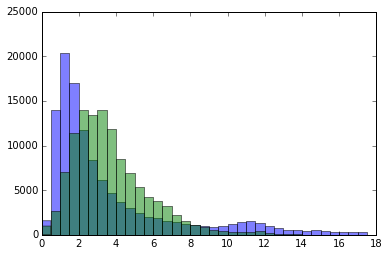

In [92]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = LR_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

In [97]:
graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],LR_model.predict(test_data))

3.264962651196299

##Evaluation using Random Forests

In [102]:
train_data,test_data = data.random_split(.5,seed=1)
RF_model = graphlab.random_forest_regression.create(train_data, target='ADLOADINGTIME',validation_set=test_data,
                                           max_iterations=20,
                                           max_depth =  50, row_subsample=0.5, random_seed=1)

Random forest regression:

--------------------------------------------------------

Number of examples          : 116524

Number of features          : 21

Number of unpacked features : 21

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 1.284073     | 17.495001          | 3.017894      | 17.744112            | 3.489371        |

| 2         | 2.718155     | 17.424749          | 2.737422      | 17.638535            | 3.335466        |

| 3         | 4.006229     | 17.073477          | 2.630950      | 17.443798            | 3.252169        |

| 4         | 5.417310     | 16.869476          | 2.575008      | 17.309799            | 3.212263        |

| 5         | 6.777387     | 16.706554          | 2.544185      | 17.372412            | 3.181038        |

| 6         | 8.012458     | 16.651981          | 2.528068      | 17.201790            | 3.162982        |

| 7         | 9.528545     | 16.750128          | 2.502120      | 17.154154            | 3.151289        |

| 8         | 10.627608    | 16.546961          | 2.502898      | 17.139425            | 3.139108        |

| 9         | 12.025688    | 16.439348          | 2.487147      | 17.123211            | 3.131564        |

| 10        | 13.338763    | 16.469315          | 2.477501      | 17.166840            | 3.127019        |

| 11        | 14.703841    | 16.479033          | 2.476710      | 17.183109            | 3.118433        |

| 12        | 16.288931    | 16.404831          | 2.467951      | 17.213974            | 3.115819        |

| 13        | 17.505001    | 16.376472          | 2.475017      | 17.206142            | 3.112236        |

| 14        | 18.959084    | 16.457619          | 2.469434      | 17.234348            | 3.108986        |

| 15        | 20.424168    | 16.454281          | 2.473143      | 17.191484            | 3.104626        |

| 16        | 21.974257    | 16.487190          | 2.465734      | 17.167410            | 3.103396        |

| 17        | 23.421339    | 16.195951          | 2.460131      | 17.134983            | 3.103533        |

| 18        | 24.663410    | 16.192352          | 2.464359      | 17.129574            | 3.101440        |

| 19        | 26.143495    | 16.211903          | 2.459454      | 17.092302            | 3.100581        |

| 20        | 27.502573    | 16.211479          | 2.464179      | 17.080765            | 3.099630        |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

(array([  0.00000000e+00,   1.74300000e+03,   7.94200000e+03,
          1.91350000e+04,   2.00480000e+04,   1.50370000e+04,
          1.05520000e+04,   7.90500000e+03,   6.22700000e+03,
          4.92500000e+03,   4.16700000e+03,   3.48500000e+03,
          3.01100000e+03,   2.53500000e+03,   2.40200000e+03,
          1.93100000e+03,   1.27700000e+03,   9.29000000e+02,
          7.02000000e+02,   5.92000000e+02,   4.91000000e+02,
          5.24000000e+02,   4.48000000e+02,   5.34000000e+02,
          3.50000000e+01,   7.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

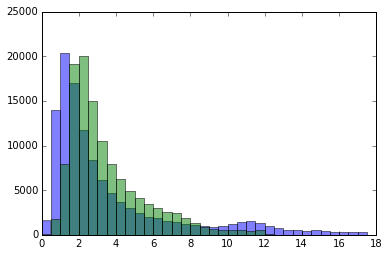

In [75]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = RF_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

##Predicting and saving

(array([  0.00000000e+00,   4.06000000e+02,   3.56300000e+03,
          1.53920000e+04,   2.01900000e+04,   1.80360000e+04,
          1.26090000e+04,   8.98800000e+03,   6.67200000e+03,
          5.46400000e+03,   4.54000000e+03,   3.95500000e+03,
          3.23800000e+03,   2.89000000e+03,   2.59000000e+03,
          2.14200000e+03,   1.42100000e+03,   1.01800000e+03,
          6.89000000e+02,   5.88000000e+02,   6.07000000e+02,
          5.46000000e+02,   5.48000000e+02,   4.14000000e+02,
          7.30000000e+01,   5.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

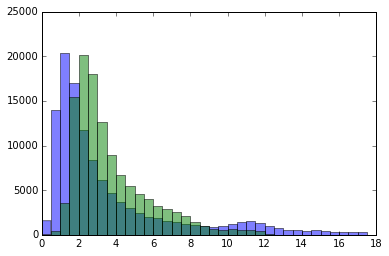

In [86]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = RF_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

In [19]:
sqft_model.save('E:\celtraMiningFrik\lin_reg_creativeid_perct_97')

In [ ]:
sqft_model = graphlab.load_model('E:\celtraMiningFrik\lin_reg_creativeid_perct_96')

In [105]:
print(graphlab.evaluation.rmse(test_data['ADLOADINGTIME'], graphlab.SArray.from_const(3.90365759806,len(test_data['ADLOADINGTIME']))))

3.72755946569


In [102]:
train_data.show()

Canvas is accessible via web browser at the URL: http://localhost:59632/index.html
Opening Canvas in default web browser.


In [ ]:
predTimes = sqft_model.predict(sales)

In [ ]:
predTimes.save('E:\celtraMiningFrik\solution4.tsv', format='csv')